# Lib Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torchvision
import torch.nn as nn
from torchinfo import summary
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.utils import make_grid

# Download Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

c:\Users\USER\Desktop\dev\codeit_sprint\codeit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.29G/2.29G [03:36<00:00, 11.4MB/s]

Extracting files...


Dataset path: C:\Users\USER\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [3]:
train_dir = os.path.join(path, "chest_xray", "train")
val_dir = os.path.join(path, "chest_xray", "val")
test_dir = os.path.join(path, "chest_xray", "test")

# Device Setting

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data preprocessing

In [5]:

transforms = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
    ]
)

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 확인
class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


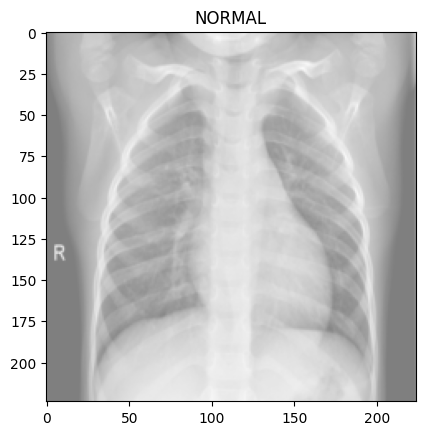

In [6]:
# 데이터 로더에서 배치 가져오기 (train)
images, labels = next(iter(train_loader))

# 이미지를 디스플레이
def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# 첫 번째 배치의 첫 번째 이미지 시각화
imshow(images[0], title=class_names[labels[0]])

In [7]:
def data_transforms(phase = None):
    if phase == 'train':
        data_T = v2.Compose([
                v2.Resize(size = (256,256)),
                v2.RandomRotation(degrees = (-20,+20)),
                v2.CenterCrop(size=224),
                v2.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == 'test' or phase == 'val':
        data_T = v2.Compose([
                v2.Resize(size = (224,224)),
                v2.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

## Load Data Sets

In [8]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms('train'))
val_dataset = datasets.ImageFolder(val_dir, data_transforms('val'))
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms('test'))

class_names = train_dataset.classes

print(class_names)
print(train_dataset.class_to_idx)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


c:\Users\USER\Desktop\dev\codeit_sprint\codeit\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## Class Count Plot

In [9]:
def plot_class_count(classes,name = None):
    pd.DataFrame(
        classes,columns = [name]
    ).groupby(
        [classes]
    ).size(
    ).plot(
        kind = 'bar',
        title = name
    )

    plt.show()

In [10]:
def get_class_count(dataset,name = None):
    classes = []
    for _,label in dataset:
        if label == 0:
            classes.append(class_names[label])
            
        elif label == 1:
            classes.append(class_names[label])
            
    return classes

### Train Class Count

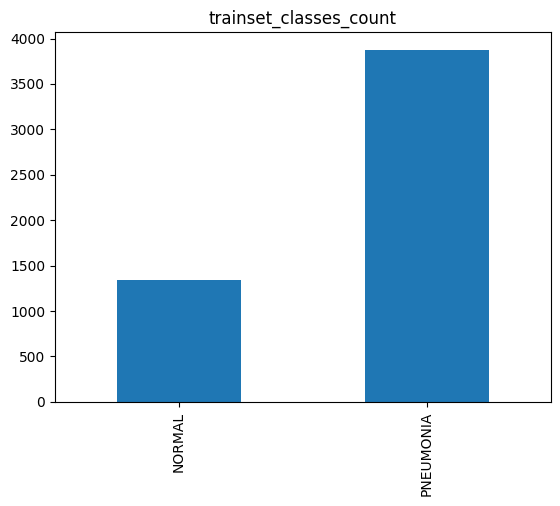

In [11]:
trainset_class_count = get_class_count(train_dataset,name = 'trainset_classes_count')
plot_class_count(trainset_class_count,name = 'trainset_classes_count')

### Test Class Count

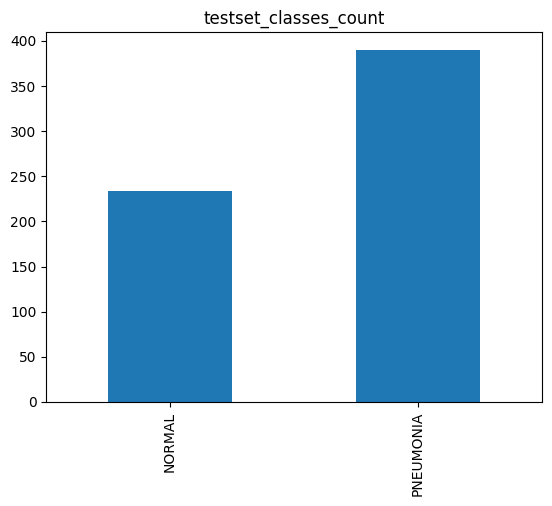

In [12]:
testset_class_count = get_class_count(test_dataset,name = 'testset_classes_count')
plot_class_count(testset_class_count,name = 'testset_classes_count')

### Valid Class Count

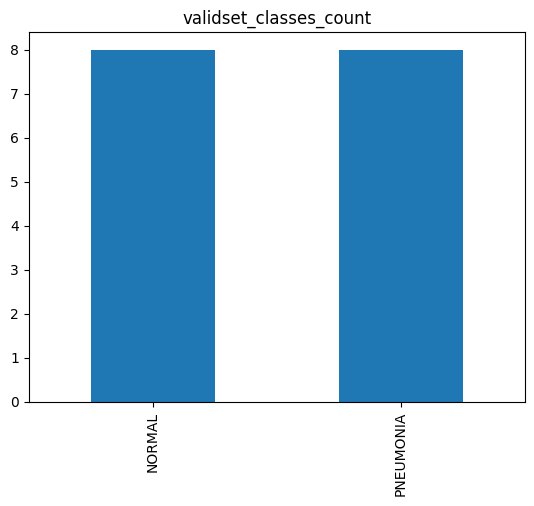

In [13]:
validset_class_count = get_class_count(val_dataset,name = 'validset_classes_count')
plot_class_count(validset_class_count,name = 'validset_classes_count')

## Loading Dataset into batches

In [14]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Plot Images

In [ ]:
def show_images_with_titles(images, labels, class_names, nrow=5, figsize=(15, 10)):
    batch_size = images.shape[0]
    ncol = nrow
    nrow = (batch_size + ncol - 1) // ncol

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    plt.figure(figsize=figsize)

    for idx in range(batch_size):
        img = images[idx].clone().detach().cpu()
        img = img.permute(1, 2, 0)
        img = (img * std) + mean
        img = torch.clamp(img, 0, 1).numpy()

        label_text = class_names[labels[idx]]

        ax = plt.subplot(nrow, ncol, idx + 1)
        ax.imshow(img)
        ax.set_title(label_text, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


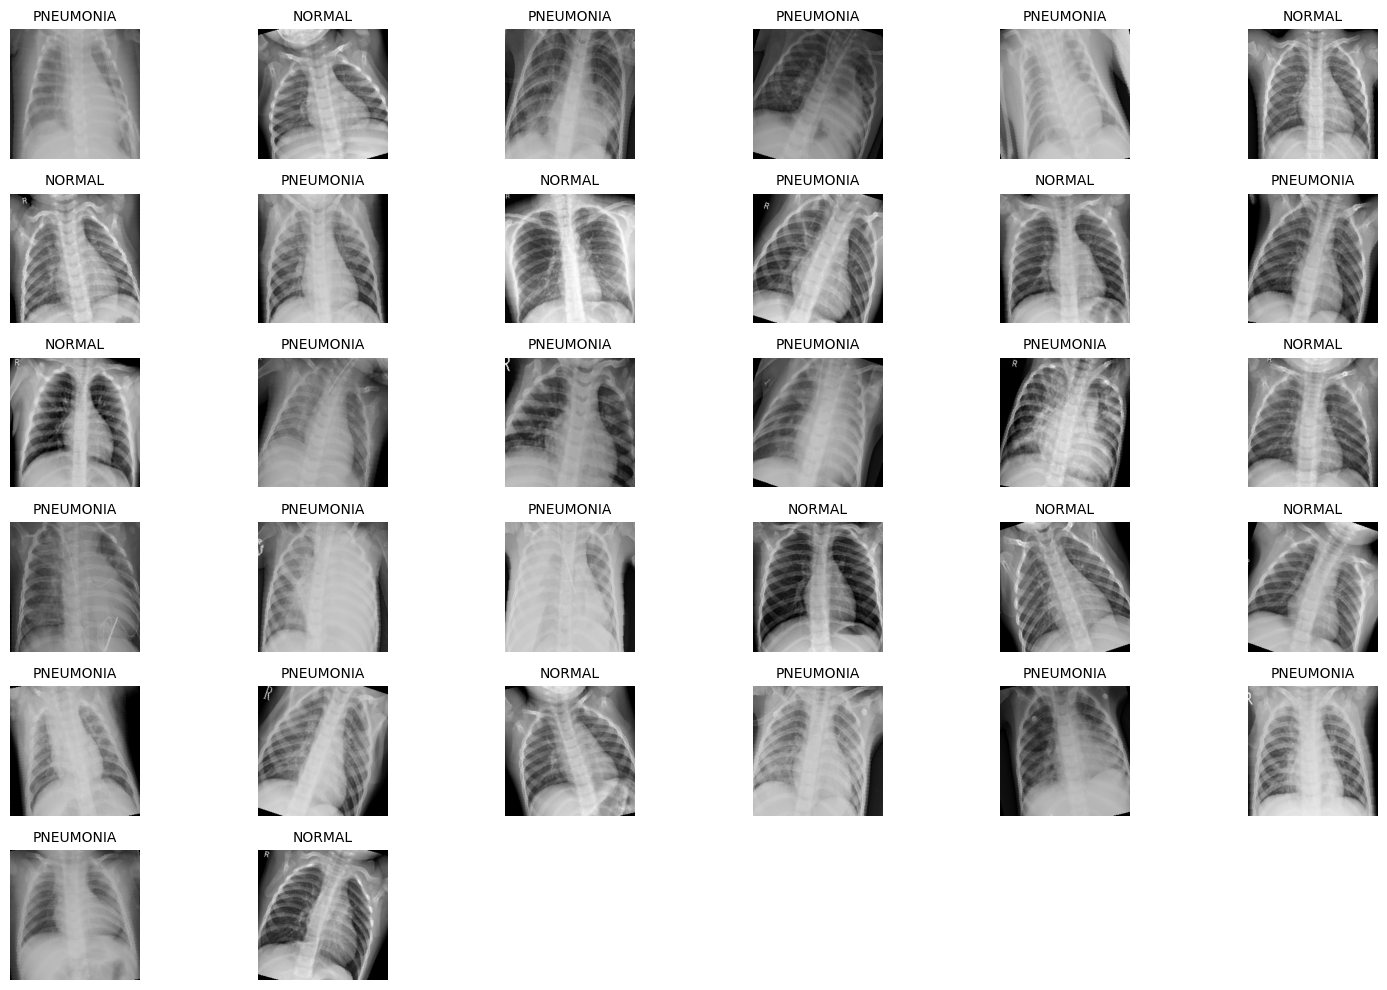

torch.Size([32, 3, 224, 224])


In [16]:
images, labels = next(iter(train_loader))

# ["NORMAL", "PNEUMONIA"]
show_images_with_titles(images, labels, class_names=class_names, nrow=6)

print(images.shape)


의사들이 흉부 X-ray를 보고 폐렴을 진단할 때 주로 보는 포인트는 다음과 같다:

| 구분 | 특징 |
| --- | --- |
| ✅ 정상(NORMAL) | 폐가 전체적으로 어두움(공기로 가득 차 있음), 폐 야영선(pulmonary markings)이 선명 |
| ❌ 폐렴(PNEUMONIA) | 폐에 흰색 음영(침윤, consolidation, fluid), 불규칙한 모양, 특정 부위가 뿌옇게 보임 |

# [Modeling] VGG-16 

In [17]:
model = models.vgg16_bn(weights='VGG16_BN_Weights.IMAGENET1K_V1')

result = summary(model=model, input_size=(32, 3, 224, 224), device=device)

print(result)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:47<00:00, 11.6MB/s] 


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 1000]                --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        128
│    └─ReLU: 2-3                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-4                       [32, 64, 224, 224]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 224, 224]        128
│    └─ReLU: 2-6                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-7                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       73,856
│    └─BatchNorm2d: 2-9                  [32, 128, 112, 112]       256
│    └─ReLU: 2-10                        [32, 128, 112, 112]       --
│    └─Conv2d: 2-11                      [32, 128, 112, 112]       147,

In [18]:
model.classifier[6] = nn.Linear(4096, 2)            # 1000→2 클래스로 교체
model = model.to(device)

In [19]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)  # AdamW: decoupled WD [oai_citation:7‡docs.pytorch.org](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?utm_source=chatgpt.com)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.1) # 학습률 스케줄러: 5 epoch마다 lr를 1/10로 감소
                                                                       # → 초반에는 빠르게 학습하고, 일정 단계 이후에는 작은 lr로 미세 조정

# Training

In [ ]:
from tqdm.auto import tqdm

train_acc_hist, val_acc_hist = [], []
EPOCHS = 10
for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    corr = tot = 0

    for x,y in tqdm(train_loader, desc=f"E{epoch+1}/{EPOCHS}"):
        x,y = x.to(device), y.to(device)
        optim.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        optim.step()
        corr += (out.argmax(1)==y).sum().item()
        tot  += y.size(0)

    train_acc_hist.append(corr / tot)

    # ---- Val ----
    model.eval(); corr = tot = 0

    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            corr += (out.argmax(1)==y).sum().item()
            tot  += y.size(0)

    val_acc_hist.append(corr / tot)
    print(f"[{epoch+1}] train:{train_acc_hist[-1]:.3f}  val:{val_acc_hist[-1]:.3f}")

    sched.step()

E1/10: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


[1] train:0.943  val:0.812


E2/10: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]


[2] train:0.967  val:0.938


E3/10: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]


[3] train:0.978  val:0.688


E4/10: 100%|██████████| 163/163 [00:58<00:00,  2.81it/s]


[4] train:0.981  val:0.938


E5/10: 100%|██████████| 163/163 [00:57<00:00,  2.82it/s]


[5] train:0.984  val:0.812


E6/10: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


[6] train:0.992  val:0.812


E7/10: 100%|██████████| 163/163 [00:59<00:00,  2.72it/s]


[7] train:0.992  val:1.000


E8/10: 100%|██████████| 163/163 [01:00<00:00,  2.72it/s]


[8] train:0.995  val:1.000


E9/10: 100%|██████████| 163/163 [00:59<00:00,  2.76it/s]


[9] train:0.996  val:0.812


E10/10: 100%|██████████| 163/163 [00:59<00:00,  2.74it/s]

[10] train:0.996  val:0.938


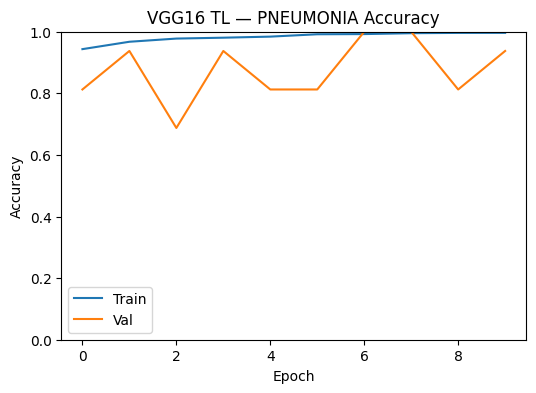

C:\Users\USER\AppData\Local\Temp\ipykernel_25136\2155480867.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ax.imshow(img.permute(1,2,0).mul(torch.tensor(IMG_STD)).add(torch.tensor(IMG_MEAN)).clamp(0,1))


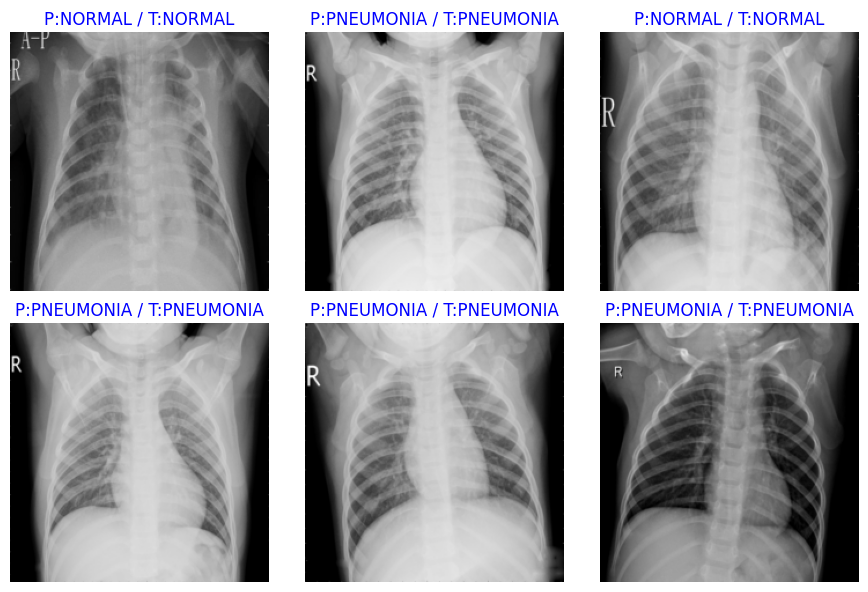

In [ ]:
IMG_MEAN = torch.tensor([0.485, 0.456, 0.406])
IMG_STD = torch.tensor([0.229, 0.224, 0.225])

# --- 1) 학습·검증 정확도 그래프 ---
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train")
plt.plot(val_acc_hist,   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.ylim(0,1)
plt.title("VGG16 TL — PNEUMONIA Accuracy")
plt.legend(); plt.show()

# ['NORMAL', 'PNEUMONIA']
# --- 2) 간단 뷰어 (예측 vs 실제) ---
import random
model.eval()
samples = random.sample(range(len(val_dataset)), 6)
fig, axes = plt.subplots(2,3, figsize=(9,6))
for ax, idx in zip(axes.flatten(), samples):
    img, label = val_dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    ax.imshow(img.permute(1,2,0).mul(torch.tensor(IMG_STD)).add(torch.tensor(IMG_MEAN)).clamp(0,1))
    ax.set_title(f"P:{'NORMAL' if pred else 'PNEUMONIA'} / T:{'NORMAL' if label else 'PNEUMONIA'}",
                 color=("b" if pred==label else "r"))
    ax.axis("off")
plt.tight_layout(); plt.show()

In [ ]:
def show_image(image, title = None, get_denormalize = False):
    
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    
    if get_denormalize == False:
        plt.figure(figsize=[15, 15])
        plt.imshow(image)

        if title != None:
            plt.title(title)
            
    else : 
        return image

In [ ]:
def view_classify(img, ps, label):
    
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    img = show_image(img,get_denormalize = True)
    

    fig, (ax1, ax2) = plt.subplots(figsize=(8, 12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

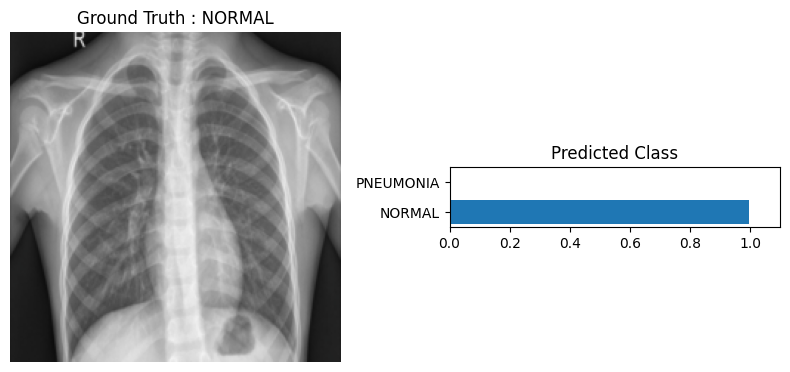

In [34]:
image,label = test_dataset[0]

ps = torch.softmax(model(image.to(device).unsqueeze(0)), dim=1)
view_classify(image, ps, label)

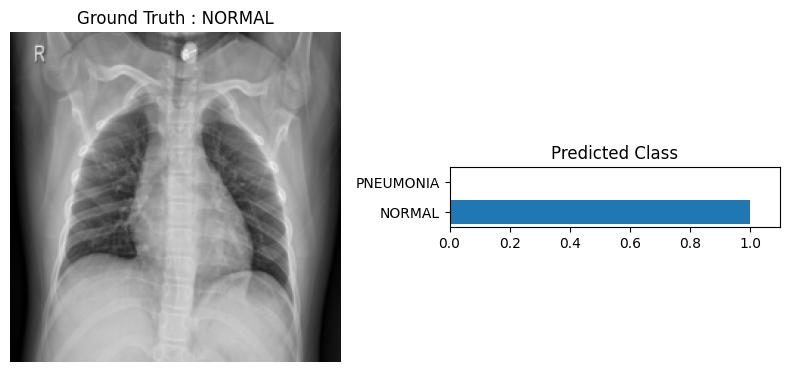

In [35]:
image,label = test_dataset[36]

ps = torch.softmax(model(image.to(device).unsqueeze(0)), dim=1)
view_classify(image,ps,label)

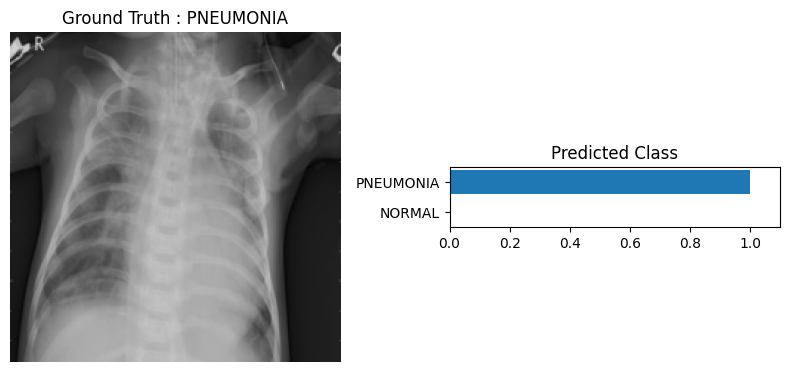

In [36]:
image,label = test_dataset[330]

ps = torch.softmax(model(image.to(device).unsqueeze(0)), dim=1)
view_classify(image,ps,label)

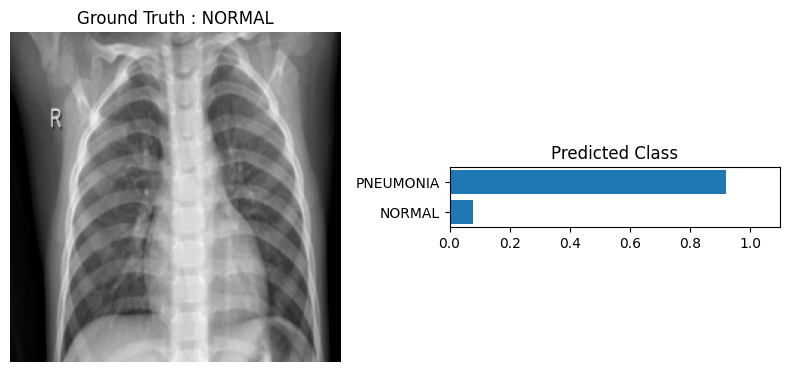

In [37]:
image,label = test_dataset[56]

ps = torch.softmax(model(image.to(device).unsqueeze(0)), dim=1)
view_classify(image,ps,label)

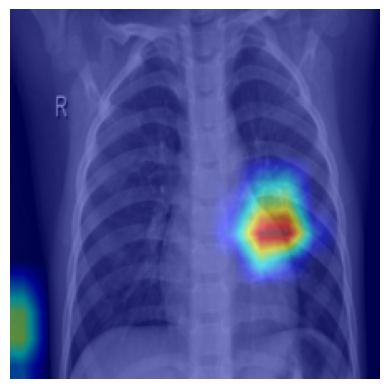

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms.functional import normalize
import torch.nn as nn

# target layer 지정 (VGG 모델 기준)
target_layer = None
for layer in reversed(model.features):
    if isinstance(layer, nn.Conv2d):
        target_layer = layer
        break

target_layers = [target_layer]

# Grad-CAM 객체 생성 (use_cuda 제거!)
cam = GradCAM(model=model.to(device), target_layers=target_layers)

# 입력 이미지 전처리
input_tensor = image.unsqueeze(0).to(device)  # shape: [1, C, H, W]

# CAM 생성
grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape: [H, W]

# 시각화용 원본 이미지 (0~1 정규화된 RGB)
rgb_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

# CAM 시각화 이미지 생성
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# 출력
import matplotlib.pyplot as plt
plt.imshow(visualization)
plt.axis('off')
plt.show()
